In [1]:
# Connect to Google Drive
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# do all of the imports
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras import layers
import joblib
import re
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load in the IMDB_sean file
df = pd.read_csv("gdrive/MyDrive/Colab Notebooks/Final-Project/Resource/IMDB_eliot3.csv")
# df = pd.read_csv("Resource/IMDB_eliot2.csv")
df.head()

,Unnamed: 0,index,movie_id,movie_name,genre,plot
0,0,76,tt0006864,Intolerance,"drama, history",intolerance story poor young woman separated p...
1,1,506,tt0017136,Metropolis,"drama, sci-fi",metropolis futuristic city sharply divided wor...
2,2,566,tt0018037,Il cantante di jazz,"drama, music, musical",il cantante di jazz son jewish cantor must def...
3,3,628,tt0018773,Il circo,"comedy, romance",il circo tramp finds work girl dreams circus
4,4,714,tt0019777,The Cocoanuts,"comedy, musical",cocoanuts florida land boom


In [4]:
df = df.drop(["Unnamed: 0", "index"], axis=1)
df["genre"] = df["genre"].str.replace(' ', '')
df["genre"] = df["genre"].str.split(",")
df.head()

,movie_id,movie_name,genre,plot
0,tt0006864,Intolerance,"[drama, history]",intolerance story poor young woman separated p...
1,tt0017136,Metropolis,"[drama, sci-fi]",metropolis futuristic city sharply divided wor...
2,tt0018037,Il cantante di jazz,"[drama, music, musical]",il cantante di jazz son jewish cantor must def...
3,tt0018773,Il circo,"[comedy, romance]",il circo tramp finds work girl dreams circus
4,tt0019777,The Cocoanuts,"[comedy, musical]",cocoanuts florida land boom


In [5]:
# get all genre tags in a list
all_genres = sum(df["genre"],[])
len(set(all_genres))

21

In [6]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

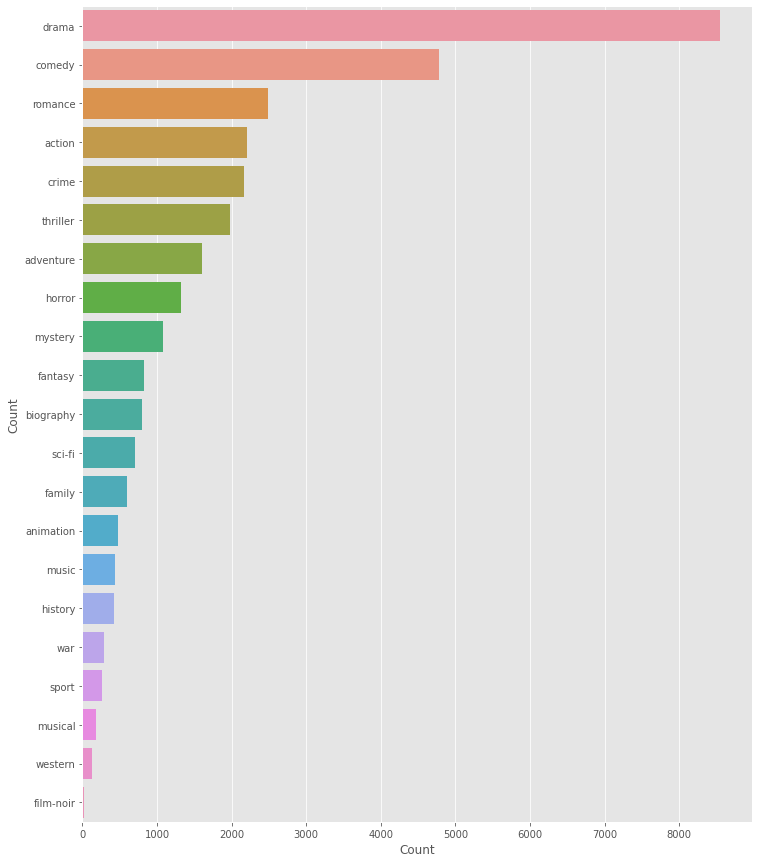

In [7]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

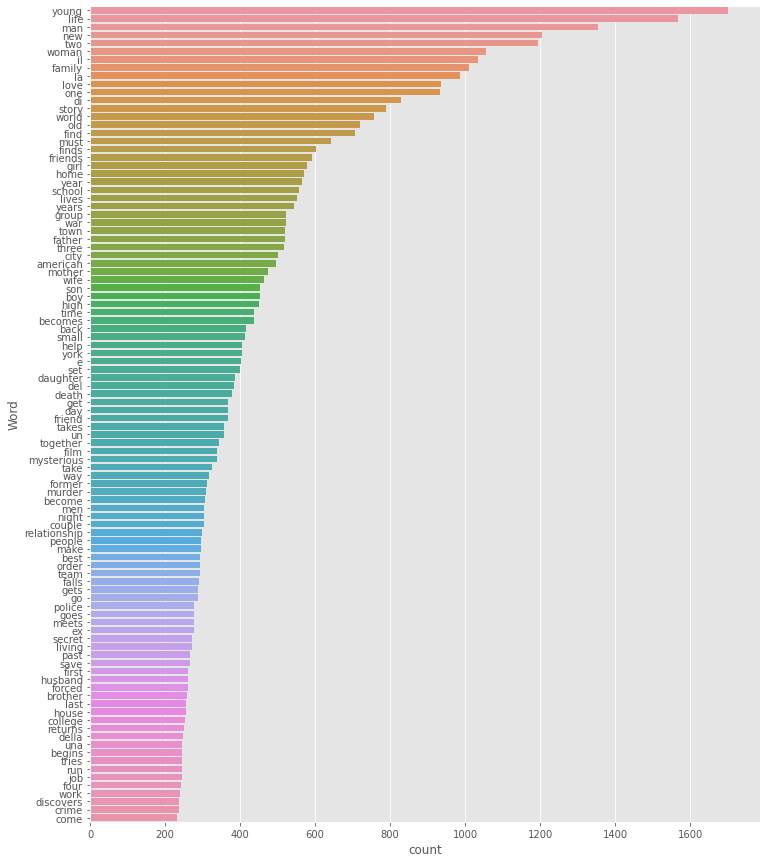

In [8]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(df['plot'], 100)

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genre'])

# transform target variable
y = multilabel_binarizer.transform(df['genre'])

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [11]:
xtrain, xval, ytrain, yval = train_test_split(df['plot'], y, test_size=0.2, random_state=9)

In [12]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [13]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [14]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [15]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [16]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [17]:
y_pred[3]

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [18]:
multilabel_binarizer.inverse_transform(y_pred)[:10]

[('drama',),
 (),
 ('drama',),
 ('crime', 'drama'),
 ('drama',),
 (),
 ('comedy',),
 ('drama',),
 ('drama',),
 ('action', 'drama')]

In [31]:
# Save the Model
file_name = "gdrive/MyDrive/Colab Notebooks/Final-Project/Saved_Models/eliot_test.h5"
joblib.dump(clf, file_name)

['gdrive/MyDrive/Colab Notebooks/Final-Project/Saved_Models/eliot_test.h5']

In [19]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.49708655577921385

In [20]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

In [21]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [22]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.5941122508548078

In [23]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower()
    
    return text

In [25]:
stop_words = set(stopwords.words("english"))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

In [26]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [27]:
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Movie: ", df['movie_name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",df['genre'][k], "\n")

Movie:  Power Rangers 
Predicted genre:  [('action',)]
Actual genre:  ['action', 'adventure', 'sci-fi'] 

Movie:  What Goes Up 
Predicted genre:  [('drama',)]
Actual genre:  ['comedy', 'drama'] 

Movie:  Spy 
Predicted genre:  [('drama',)]
Actual genre:  ['action', 'crime', 'drama'] 

Movie:  Bamboozled 
Predicted genre:  [('drama',)]
Actual genre:  ['comedy', 'drama', 'music'] 

Movie:  Verdetto finale 
Predicted genre:  [('crime', 'drama')]
Actual genre:  ['action', 'crime', 'drama'] 



In [53]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

cm = multilabel_confusion_matrix(yval, y_pred)
cm

array([[[2153,   22],
        [ 369,  112]],

       [[2313,    5],
        [ 297,   41]],

       [[2563,    0],
        [  93,    0]],

       [[2484,    3],
        [ 157,   12]],

       [[1599,  137],
        [ 540,  380]],

       [[2202,   31],
        [ 308,  115]],

       [[ 374,  552],
        [ 171, 1559]],

       [[2527,    0],
        [ 129,    0]],

       [[2495,    0],
        [ 161,    0]],

       [[2651,    0],
        [   5,    0]],

       [[2566,    0],
        [  90,    0]],

       [[2380,    9],
        [ 245,   22]],

       [[2579,    0],
        [  75,    2]],

       [[2622,    0],
        [  34,    0]],

       [[2433,    7],
        [ 214,    2]],

       [[2134,   46],
        [ 396,   80]],

       [[2501,    0],
        [ 144,   11]],

       [[2604,    0],
        [  52,    0]],

       [[2273,    9],
        [ 364,   10]],

       [[2600,    0],
        [  56,    0]],

       [[2630,    0],
        [  26,    0]]])

In [60]:
new_cm = cm.reshape(-42, 42)

In [58]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [51]:
all_genres_df["Genre"]

0         drama
1       history
2        sci-fi
3         music
4       musical
5        comedy
6       romance
7         crime
8           war
9       western
10       horror
11    adventure
12       family
13      fantasy
14      mystery
15     thriller
16    biography
17    animation
18       action
19    film-noir
20        sport
Name: Genre, dtype: object

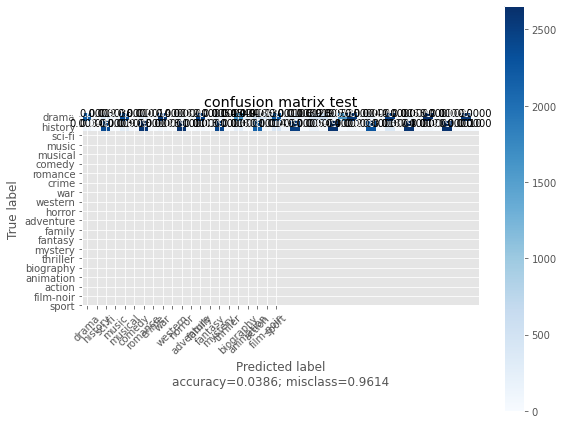

In [67]:
plot_confusion_matrix(new_cm, all_genres_df["Genre"], "confusion matrix test", cmap=None, normalize=True)